In [1]:
n=10000
m=10
p=3 #Barabasi-Albert parameter
init_Theta=0.05#0.06
N=10 #number of time steps
r=0 #0.3 #szansa aktywacji przy negatywnej korelacji
prob=0.20 #prawd. aktywności użytkownika w danej epidemii (do generaowania macierzy)
a=0.15#0.04 # parameter kształtu powr-law

In [2]:
%matplotlib inline

import copy
import math
import pandas as pd
import matplotlib
import numpy as np
np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import networkx as nx
import scipy.sparse as sparse
import asizeof
from collections import defaultdict
G=nx.barabasi_albert_graph(n, p)
print('1.Undirected graph done!')
G=G.to_directed()
print('2.Directed graph done!')
for u,v in tqdm(G.edges()):
    G[u][v]['weight']=1.0#np.random.uniform(0,1)
print('3.Wieghts assigned!')
for i in tqdm(range(n)):
    in_degree=G.in_degree(i,weight='weight')
    for u,v in G.in_edges(i):
        #print(u,v,G[u][v]['weight'],G[u][v]['weight'] / in_degree, in_degree)
        G[u][v]['weight']/=in_degree
print('4.Wieghts normalized!')
W=nx.adjacency_matrix(G,weight='weight')
print('4.Adjacency (sparse) matrix created!')

1.Undirected graph done!
2.Directed graph done!


HBox(children=(IntProgress(value=0, max=59982), HTML(value='')))


3.Wieghts assigned!


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


4.Wieghts normalized!
4.Adjacency (sparse) matrix created!


In [3]:
C = np.random.random((m, m))
C=C*2-1
C *= np.tri(*C.shape,k=-1)
C=C+np.transpose(C)+np.eye(m)
print(C.min(),C.max(),C.mean(),np.median(C))
print("Correlation matrix done!")

-0.994210761621 1.0 0.0202256085746 0.0550340548402
Correlation matrix done!


In [4]:
indykatory=[]
frakcje=[]
import scipy.stats as stats
frac_inf=np.ceil(stats.powerlaw.rvs(a,size=(m))*n).astype(int)
I=np.full((n, m), False, dtype=bool)
for i in tqdm(range(m)):
    I[np.ix_(stats.randint.rvs(0, n-1, size=frac_inf[i]),[i])]=True
indykatory.append(I)
frakcje.append(np.vstack((range(m),np.sum(I,axis=0)/n)))
I=copy.deepcopy(I)
print("Initial state assigned!")

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Initial state assigned!


In [5]:
Theta=np.full((n,m), init_Theta)
print("Initial Theta assigned!")

Initial Theta assigned!


In [6]:
Y=np.full((n,1),0)
print("Activation counter initiated!")

Activation counter initiated!


In [7]:
df=[]
for l in tqdm(range(N)):    
    U=W.transpose().dot(I)
    F=U.dot(C)/m
    #print(F.min(),F.max(),F.mean(),l)
    temp=np.greater_equal(F, Theta) #porównanie funkcji aktywacji z progiem
    ### dodawanie rekordów bez przekroczenia progu
    for i in np.unique(np.where(temp[:,:]==False)[0]):
        temp1=np.where(temp[i,:]==False)[0] #tagi, w których dla użytkownika i przekroczony nie był próg
        temp2=np.where(I[i][:]==True)[0] #tagi juz aktywne
        temp1=np.setdiff1d(temp1,temp2) #usuniecie juz aktywnych tagow
        for j in temp1:
            df.append([i,copy.deepcopy(F[i][j]),0,copy.deepcopy(Y[i][0])])
    ###
    for i in np.unique(np.where(temp[:,:]==True)[0]): #iteracja po użytkownikach, którzy mają przekroczony próg
        temp1=np.where(temp[i,:]==True)[0] #tagi, w których dla użytkownika i przekroczony był próg
        temp2=np.where(I[i][:]==True)[0] #tagi juz aktywne
        temp1=np.setdiff1d(temp1,temp2) #usuniecie juz aktywnych tagow
    ### dodawanie rekordów z przekroczeniem progów
        for j in temp1:
            df.append([i,copy.deepcopy(F[i][j]),1,copy.deepcopy(Y[i][0])])
    ### 
        if (not np.any(C[temp1[:, None],temp1]<0)) and (not temp1.size==0): #sprawdzenie, czy kandydaci do aktywacji nie są negatywnie skorelowani
            I[i][temp1]=True #aktywacja uzytkownika i w tagach z listy temp1
            Y[i][0]+=1#Y[i]+=1 #zwiekszenie licznika aktywacji uzytkownika i
            Theta[i]=1-math.pow(1-init_Theta,Y[i][0]+1) #aktualizacja thety
        else:
            if (np.random.rand()<r) and (not temp1.size==0): #aktywacji pomimo negatywnej korelacji z pr. r
                I[i][temp1]=True
                Y[i][0]+=1
                Theta[i]=1-math.pow(1-init_Theta,Y[i][0]+1)
                if temp1.size==0:
                    print('empty!')
    indykatory.append(I)
    frakcje.append(np.vstack((range(m),np.sum(I,axis=0)/n)))
    I=copy.deepcopy(I)
del temp

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

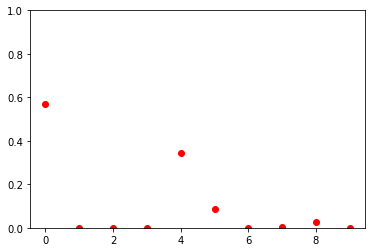

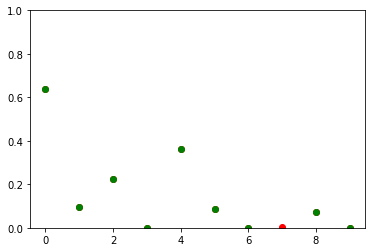

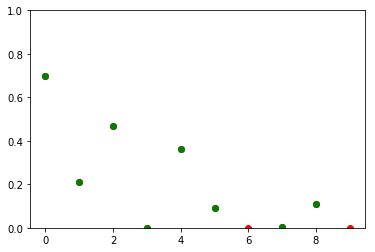

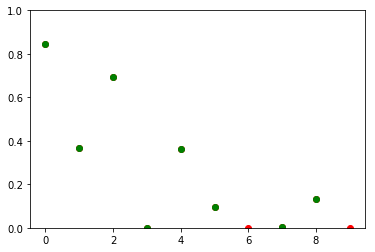

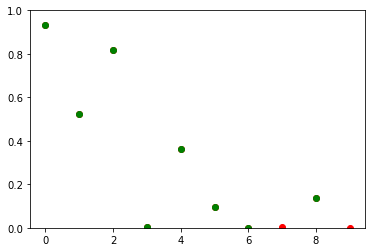

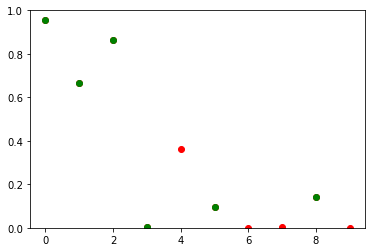

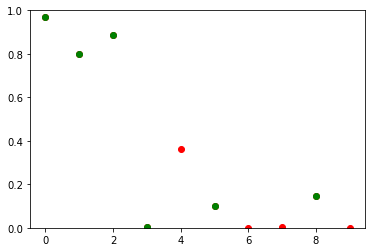

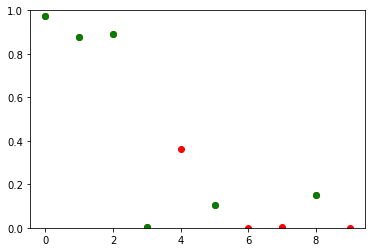

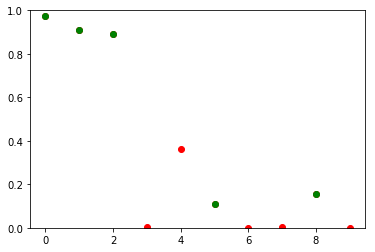

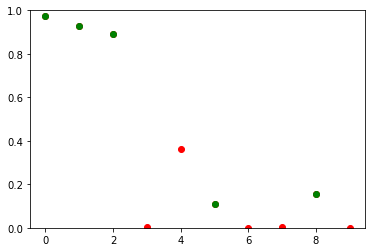

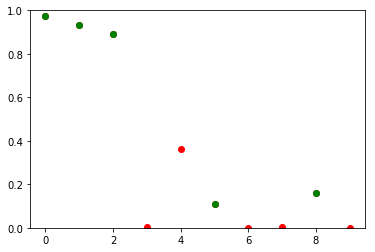

In [8]:
for i in range(N+1):
    plt.plot(frakcje[i][1], 'ro')
    axes = plt.gca()
    axes.set_ylim([0,1])
    if i>0:
        wzrost=frakcje[i][np.ix_([0,1],np.where(frakcje[i]>frakcje[i-1])[1])]
        plt.plot(wzrost[0],wzrost[1], 'go')
    plt.show()

In [9]:
for i in range(N):
    if np.array_equal(indykatory[i],indykatory[i+1])==True:
        print(i)

In [10]:
import pandas as pd
df=pd.DataFrame(df)
df.columns=['user','x','y','w']

## Logistic Regression

In [11]:
from pandas import DataFrame
from sklearn import preprocessing
from numpy import loadtxt, where
from pylab import scatter, show, legend, xlabel, ylabel

##The sigmoid function adjusts the cost function hypotheses to adjust the algorithm proportionally for worse estimations
def Sigmoid(z):
    G_of_Z = float(1.0 / float((1.0 + math.exp(-1.0*z))))
    return G_of_Z

##The hypothesis is the linear combination of all the known factors x[i] and their current estimated coefficients theta[i] 
##This hypothesis will be used to calculate each instance of the Cost Function
def Hypothesis(theta, x):
    z = x-theta
    return Sigmoid(z)

##For each member of the dataset, the result (Y) determines which variation of the cost function is used
##The Y = 0 cost function punishes high probability estimations, and the Y = 1 it punishes low scores
##The "punishment" makes the change in the gradient of ThetaCurrent - Average(CostFunction(Dataset)) greater
def Cost_Function(X,Y,theta,m):
    sumOfErrors = 0
    for i in range(m):
        hi = Hypothesis(theta,X[i])
        error=Y[i]*math.log(hi)+(1-Y[i])*math.log(1-hi)
        sumOfErrors += error
    const = -1/m
    J = const * sumOfErrors
    return J

##This function creates the gradient component for each Theta value 
##The gradient is the partial derivative by Theta of the current value of theta minus 
##a "learning speed factor aplha" times the average of all the cost functions for that theta
##For each Theta there is a cost function calculated for each member of the dataset
def Cost_Function_Derivative(X,Y,theta,m,alpha):
    sumErrors = 0
    for i in range(m):
        xi = X[i]
        hi = Hypothesis(theta,xi)
        error = -1.0*(hi - Y[i])
        sumErrors += error
    constant = float(alpha)/float(m)
    J = constant * sumErrors
    return J


##For each theta, the partial differential 
##The gradient, or vector from the current point in Theta-space (each theta value is its own dimension) to the more accurate point, 
##is the vector with each dimensional component being the partial differential for each theta value
def Gradient_Descent(X,Y,theta,m,alpha):
    CFDerivative = Cost_Function_Derivative(X,Y,theta,m,alpha)
    new_theta = theta-CFDerivative
    return [new_theta, CFDerivative]

##The high level function for the LR algorithm which, for a number of steps (num_iters) finds gradients which take 
##the Theta values (coefficients of known factors) from an estimation closer (new_theta) to their "optimum estimation" which is the
##set of values best representing the system in a linear combination model
def Logistic_Regression(X,Y,alpha,theta,num_iters):
    m = len(Y)
    cost=[Cost_Function(X,Y,theta,m)]
    Theta=[theta]
    gradient=[]
    for x in range(num_iters):
        GD = Gradient_Descent(X,Y,theta,m,alpha)
        theta = GD[0]
        gradient.append(GD[1])
        cost.append(Cost_Function(X,Y,theta,m))
        Theta.append(theta)
        if abs(GD[1])<0.00001:
            break
        #if x % 100 == 0:
            #here the cost function is used to present the final hypothesis of the model in the same form for each gradient-step iteration
            #print("theta ", theta, " at ",x,"-th iteration")
            #print("cost is ", Cost_Function(X,Y,W,theta,m))
    return [Theta,cost,gradient]

In [12]:
from joblib import Parallel, delayed
import time
def text_progessbar(seq, total=None):
    step = 1
    tick = time.time()
    while True:
        time_diff = time.time()-tick
        avg_speed = time_diff/step
        total_str = 'of %n' % total if total else ''
        print('user', step, '%.2f' % time_diff, 'avg: %.2f iter/sec' % avg_speed, total_str)
        step += 1
        yield next(seq)
all_bar_funcs = {
    'txt': lambda args: lambda x: text_progessbar(x, **args),
    'None': lambda args: iter,
}
def ParallelExecutor(use_bar='tqdm', **joblib_args):
    def aprun(bar=use_bar, **tq_args):
        def tmp(op_iter):
            if str(bar) in all_bar_funcs.keys():
                bar_func = all_bar_funcs[str(bar)](tq_args)
            else:
                raise ValueError("Value %s not supported as bar type"%bar)
            return Parallel(**joblib_args)(bar_func(op_iter))
        return tmp
    return aprun
n_jobs=22
aprun = ParallelExecutor(n_jobs=n_jobs)

## Data preprocessing

In [13]:
def Estimate_theta(df,user,initial_theta,alpha,num_iters):
    res=[]
    for i in df[df['user']==user]['w'].unique():
        X=df[(df['user']==user) & (df['w']==i)]
        Y=X['y']
        Y=np.array(Y)#.reshape(-1, 1)
        #print('srednia z W to ',np.mean(W))
        X=X['x']
        X=np.array(X).reshape(-1, 1)
        mini=X.min(axis=0)
        maxi=X.max(axis=0)
        X=((X - mini) / (maxi - mini))*2-1
        initial_theta=1-math.pow(1-initial_theta,i+1)
        #initial_theta=((initial_theta - mini) / (maxi - mini))*2-1
        LR=Logistic_Regression(X,Y,alpha,initial_theta,num_iters)
        LR[0]=[(x+1)/2*(maxi-mini)+mini for x in LR[0]]
        #LR[0]=[0 if x>1 else x for x in LR[0]]
        LR[0]=[1-math.pow(1-x,1/float(i+1)) for x in LR[0]]
        res.append(LR)
    return res

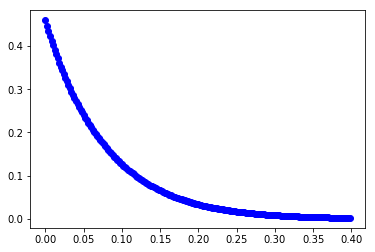

In [21]:
i=1
X=df[(df['user']==0) & (df['w']==i)]
Y=X['y']
Y=np.array(Y)#.reshape(-1, 1)
#print('srednia z W to ',np.mean(W))
X=X['x']
X=np.array(X).reshape(-1, 1)
mini=X.min(axis=0)
maxi=X.max(axis=0)
X=((X - mini) / (maxi - mini))*2-1
m=len(Y)
for j in np.arange(-0,0.4,0.002):
    plt.plot(j,1-math.pow(1-Cost_Function(X,Y,((j - mini) / (maxi - mini))*2-1,m),1/float(i+1)),'bo')
plt.show()

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

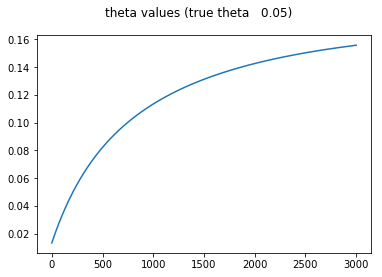

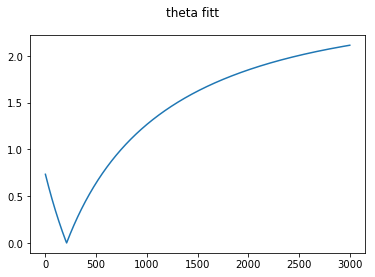

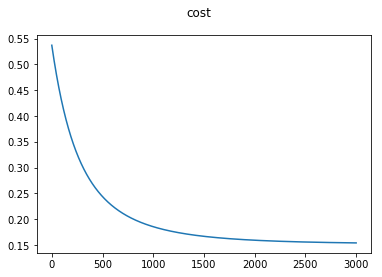

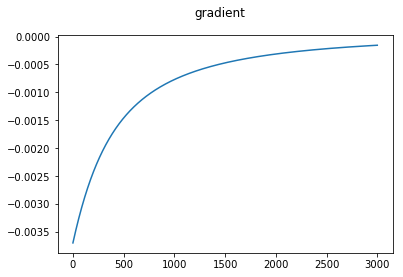

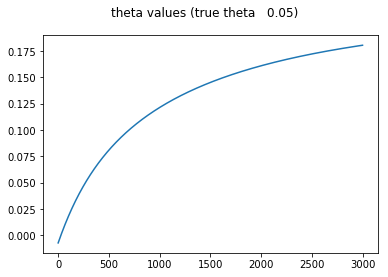

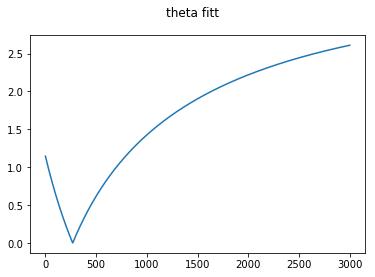

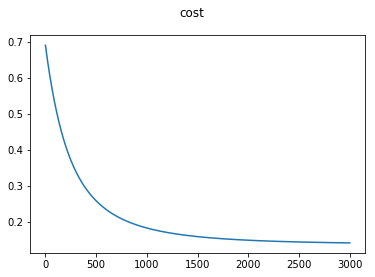

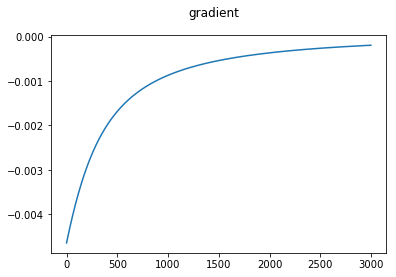

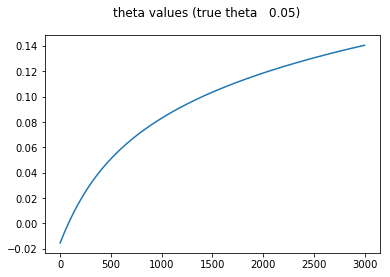

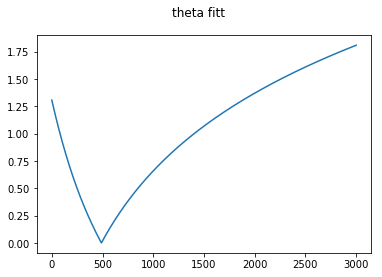

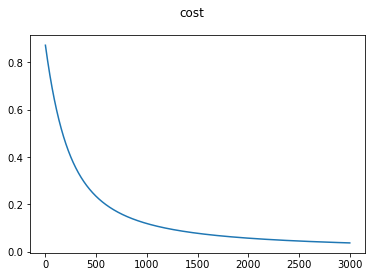

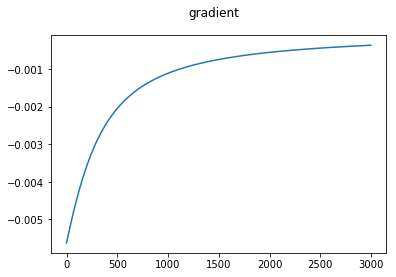

In [19]:
initial_theta = 0
alpha = 0.05
iterations = 3000
user=1
res=Estimate_theta(df,user,initial_theta,alpha,iterations)
for i in tqdm(range(len(res))):
    initial_Theta=init_Theta
    #print(initial_theta)
    fig=plt.figure()
    plt.plot(res[i][0])
    fig.suptitle(f'theta values (true theta {initial_Theta:6.5})')
    plt.show()
    fig=plt.figure()
    plt.plot([np.abs(x - initial_Theta)/ initial_Theta for x in res[i][0]])
    fig.suptitle('theta fitt')
    plt.show()
    fig=plt.figure()
    plt.plot(res[i][1])
    fig.suptitle('cost')
    plt.show()
    fig=plt.figure()
    plt.plot(res[i][2])
    fig.suptitle('gradient')
    plt.show()

user 1 0.00 avg: 0.00 iter/sec 
user 2 0.00 avg: 0.00 iter/sec 
user 3 0.01 avg: 0.00 iter/sec 
user 4 0.01 avg: 0.00 iter/sec 
user 5 0.01 avg: 0.00 iter/sec 
user 6 0.01 avg: 0.00 iter/sec 
user 7 0.01 avg: 0.00 iter/sec 
user 8 0.02 avg: 0.00 iter/sec 
user 9 0.02 avg: 0.00 iter/sec 
user 10 0.02 avg: 0.00 iter/sec 
user 11 0.02 avg: 0.00 iter/sec 
user 12 0.02 avg: 0.00 iter/sec 
user 13 0.03 avg: 0.00 iter/sec 
user 14 0.03 avg: 0.00 iter/sec 
user 15 0.03 avg: 0.00 iter/sec 
user 16 0.03 avg: 0.00 iter/sec 
user 17 0.03 avg: 0.00 iter/sec 
user 18 0.04 avg: 0.00 iter/sec 
user 19 0.04 avg: 0.00 iter/sec 
user 20 0.04 avg: 0.00 iter/sec 
user 21 0.04 avg: 0.00 iter/sec 
user 22 0.04 avg: 0.00 iter/sec 
user 23 0.04 avg: 0.00 iter/sec 
user 24 0.04 avg: 0.00 iter/sec 
user 25 0.05 avg: 0.00 iter/sec 
user 26 0.05 avg: 0.00 iter/sec 
user 27 0.05 avg: 0.00 iter/sec 
user 28 0.05 avg: 0.00 iter/sec 
user 29 0.05 avg: 0.00 iter/sec 
user 30 0.05 avg: 0.00 iter/sec 
user 31 0.05 avg: 0

user 240 85.89 avg: 0.36 iter/sec 
user 241 86.23 avg: 0.36 iter/sec 
user 242 88.10 avg: 0.36 iter/sec 
user 243 89.17 avg: 0.37 iter/sec 
user 244 89.55 avg: 0.37 iter/sec 
user 245 89.68 avg: 0.37 iter/sec 
user 246 90.07 avg: 0.37 iter/sec 
user 247 90.30 avg: 0.37 iter/sec 
user 248 91.98 avg: 0.37 iter/sec 
user 249 92.03 avg: 0.37 iter/sec 
user 250 92.11 avg: 0.37 iter/sec 
user 251 92.54 avg: 0.37 iter/sec 
user 252 92.87 avg: 0.37 iter/sec 
user 253 92.95 avg: 0.37 iter/sec 
user 254 93.03 avg: 0.37 iter/sec 
user 255 93.11 avg: 0.37 iter/sec 
user 256 93.16 avg: 0.36 iter/sec 
user 257 93.34 avg: 0.36 iter/sec 
user 258 93.42 avg: 0.36 iter/sec 
user 259 93.57 avg: 0.36 iter/sec 
user 260 93.65 avg: 0.36 iter/sec 
user 261 94.07 avg: 0.36 iter/sec 
user 262 94.58 avg: 0.36 iter/sec 
user 263 95.77 avg: 0.36 iter/sec 
user 264 97.02 avg: 0.37 iter/sec 
user 265 98.47 avg: 0.37 iter/sec 
user 266 98.54 avg: 0.37 iter/sec 
user 267 99.19 avg: 0.37 iter/sec 
user 268 99.68 avg: 

user 470 182.45 avg: 0.39 iter/sec 
user 471 182.50 avg: 0.39 iter/sec 
user 472 182.58 avg: 0.39 iter/sec 
user 473 183.76 avg: 0.39 iter/sec 
user 474 183.89 avg: 0.39 iter/sec 
user 475 184.14 avg: 0.39 iter/sec 
user 476 184.19 avg: 0.39 iter/sec 
user 477 185.29 avg: 0.39 iter/sec 
user 478 185.72 avg: 0.39 iter/sec 
user 479 185.77 avg: 0.39 iter/sec 
user 480 186.21 avg: 0.39 iter/sec 
user 481 186.22 avg: 0.39 iter/sec 
user 482 186.64 avg: 0.39 iter/sec 
user 483 187.58 avg: 0.39 iter/sec 
user 484 187.67 avg: 0.39 iter/sec 
user 485 188.94 avg: 0.39 iter/sec 
user 486 189.28 avg: 0.39 iter/sec 
user 487 189.33 avg: 0.39 iter/sec 
user 488 189.55 avg: 0.39 iter/sec 
user 489 190.24 avg: 0.39 iter/sec 
user 490 190.32 avg: 0.39 iter/sec 
user 491 191.03 avg: 0.39 iter/sec 
user 492 191.14 avg: 0.39 iter/sec 
user 493 191.73 avg: 0.39 iter/sec 
user 494 192.26 avg: 0.39 iter/sec 
user 495 192.48 avg: 0.39 iter/sec 
user 496 192.99 avg: 0.39 iter/sec 
user 497 193.32 avg: 0.39 it

user 698 277.23 avg: 0.40 iter/sec 
user 699 277.34 avg: 0.40 iter/sec 
user 700 277.77 avg: 0.40 iter/sec 
user 701 277.90 avg: 0.40 iter/sec 
user 702 280.01 avg: 0.40 iter/sec 
user 703 280.49 avg: 0.40 iter/sec 
user 704 281.03 avg: 0.40 iter/sec 
user 705 281.26 avg: 0.40 iter/sec 
user 706 281.36 avg: 0.40 iter/sec 
user 707 281.41 avg: 0.40 iter/sec 
user 708 281.82 avg: 0.40 iter/sec 
user 709 281.98 avg: 0.40 iter/sec 
user 710 282.55 avg: 0.40 iter/sec 
user 711 282.80 avg: 0.40 iter/sec 
user 712 283.49 avg: 0.40 iter/sec 
user 713 283.56 avg: 0.40 iter/sec 
user 714 283.61 avg: 0.40 iter/sec 
user 715 283.96 avg: 0.40 iter/sec 
user 716 284.25 avg: 0.40 iter/sec 
user 717 284.93 avg: 0.40 iter/sec 
user 718 286.00 avg: 0.40 iter/sec 
user 719 286.07 avg: 0.40 iter/sec 
user 720 286.57 avg: 0.40 iter/sec 
user 721 286.82 avg: 0.40 iter/sec 
user 722 287.52 avg: 0.40 iter/sec 
user 723 287.79 avg: 0.40 iter/sec 
user 724 287.87 avg: 0.40 iter/sec 
user 725 288.98 avg: 0.40 it

user 926 372.08 avg: 0.40 iter/sec 
user 927 372.13 avg: 0.40 iter/sec 
user 928 372.18 avg: 0.40 iter/sec 
user 929 372.38 avg: 0.40 iter/sec 
user 930 374.09 avg: 0.40 iter/sec 
user 931 374.13 avg: 0.40 iter/sec 
user 932 374.22 avg: 0.40 iter/sec 
user 933 374.41 avg: 0.40 iter/sec 
user 934 374.72 avg: 0.40 iter/sec 
user 935 374.80 avg: 0.40 iter/sec 
user 936 375.18 avg: 0.40 iter/sec 
user 937 375.39 avg: 0.40 iter/sec 
user 938 376.15 avg: 0.40 iter/sec 
user 939 377.35 avg: 0.40 iter/sec 
user 940 377.48 avg: 0.40 iter/sec 
user 941 378.40 avg: 0.40 iter/sec 
user 942 378.64 avg: 0.40 iter/sec 
user 943 379.15 avg: 0.40 iter/sec 
user 944 379.28 avg: 0.40 iter/sec 
user 945 379.37 avg: 0.40 iter/sec 
user 946 380.06 avg: 0.40 iter/sec 
user 947 381.16 avg: 0.40 iter/sec 
user 948 381.24 avg: 0.40 iter/sec 
user 949 381.41 avg: 0.40 iter/sec 
user 950 381.87 avg: 0.40 iter/sec 
user 951 382.56 avg: 0.40 iter/sec 
user 952 382.63 avg: 0.40 iter/sec 
user 953 382.88 avg: 0.40 it

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

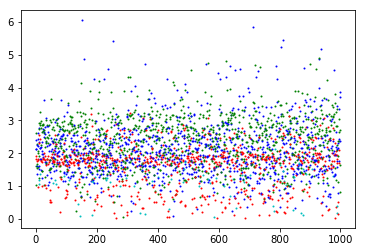

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

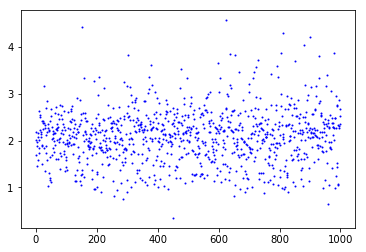

In [17]:
n=1000
initial_theta = np.random.random_sample(n)/10
alpha = 0.01
iterations = 3000
colors=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
results=aprun(bar='txt')(delayed(Estimate_theta)(df,i,initial_theta[i],alpha,iterations) for i in range(n))
for i in tqdm(range(n)):
    for j in range(len(results[i])):#range(1):
        initial_Theta=init_Theta
        plt.plot(i,np.abs(results[i][j][0][-1] - initial_Theta)/ initial_Theta,colors[j]+'o',ms=1)
plt.show()
for i in tqdm(range(n)):
    mean_theta=[]
    for j in range(len(results[i])):#range(1):
        mean_theta.append(results[i][j][0][-1])
    initial_Theta=init_Theta
    plt.plot(i,np.abs(np.mean(mean_theta) - initial_Theta)/ initial_Theta,'bo',ms=1)
plt.show()

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

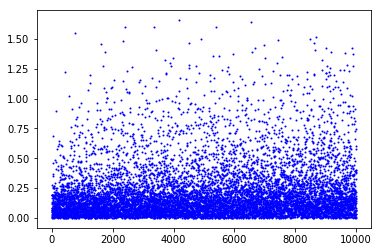

In [15]:
for i in tqdm(range(n)):
    mean_theta=[]
    for j in range(len(results[i])):#range(1):
        mean_theta.append(results[i][j][0][-1])
    initial_Theta=init_Theta
    plt.plot(i,np.abs(np.mean(mean_theta) - initial_Theta)/ initial_Theta,'bo',ms=1)
plt.show()

In [43]:
!git add CC

Initialized empty Git repository in /home/jovyan/Prediction of Viral Memes/.git/


In [ ]:
# def plot_results(results,user):
#     for j in range(len(results[user])):#range(1):
#         initial_Theta=init_Theta
#         plt.plot(user,np.abs(results[user][j][0][-1] - initial_Theta)/ initial_Theta,colors[j]+'o',ms=1)
# aprun(bar='txt')(delayed(plot_results)(results,i) for i in range(n))
# plt.show()

In [ ]:
initial_theta = np.random.random_sample(1000)/10
alpha = 0.05
iterations = 100
results=aprun(bar='txt')(delayed(Estimate_theta)(df,i,initial_theta[i],alpha,iterations) for i in range(1000))
est_theta=[]
cost=[]
hist_theta=[]
gradient=[]
for i in range(1000):
    est_theta.append(results[i][0][100])
    hist_theta.append(results[i][0])
    cost.append(results[i][1])
    gradient.append(results[i][2])
plt.plot([np.abs(x - init_Theta)/ init_Theta for x in est_theta],'bo')
plt.show()
plt.plot(np.mean(np.array(cost), axis=0))
plt.show()
dop_theta=[]
for i in range(1000):
    dop_theta.append([np.abs(x - init_Theta)/ init_Theta for x in hist_theta[i]])
plt.plot(np.mean(np.array(dop_theta), axis=0))
plt.show()
for i in range(1000):
    dop_theta[i]=[(x-min(dop_theta[i]))/(max(dop_theta[i])-min(dop_theta[i])) for x in dop_theta[i]]
plt.plot(np.mean(np.array(dop_theta), axis=0))
plt.show()
plt.plot(np.mean(np.array(gradient), axis=0)[1:])
plt.show()

In [ ]:
plt.hist(np.array(cost)[:,98])
plt.show()

##### Wykres masymalnego w / liczba aktywnych kampanii na koniec procesu dla wszystkich użytkowników

In [ ]:
tmp=[]
for i in tqdm(range(df['user'].max()+1)):
    tmp.append(sum(indykatory[N][i,:])/Y[i])
plt.plot(tmp,'bo')
del tmp

#### Różnica pomiędzy liczbą aktywacji z indykatorów, a licznikiem aktywacji

In [ ]:
tmp=[]
for i in tqdm(range(n)):
    tmp.append(sum(np.logical_xor(indykatory[N][i,:],indykatory[0][i,:]))-Y[i][0])
    #if sum(np.logical_xor(indykatory[N][i,:],indykatory[0][i,:]))-Y[i][0]<0:
     #   print(i)
plt.hist(tmp)
plt.show()
plt.plot(tmp,'bo')
plt.show()
del tmp